In [1]:
import numpy as np
import pandas as pd
import gpflow
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split

from gpflow.test_util import notebook_niter

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)
data

,H0,H1,H2,H3,H4,H5,H6,H7,H8,K0,...,E2,E3,E4,E5,E6,E7,E8,Geschoben,Player,Aktion
0,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,1631,2
1,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,64310,6
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,16721,1
3,1,0,0,0,1,0,0,0,1,1,...,0,0,1,0,1,0,0,1,0,4
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,72620,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161689,0,1,0,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,55942,3
161690,0,0,1,0,0,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,6
161691,0,0,0,0,0,0,1,0,0,0,...,0,0,1,1,0,1,0,0,0,3
161692,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,60659,6


## Multiclass Classification (without _schieben_)

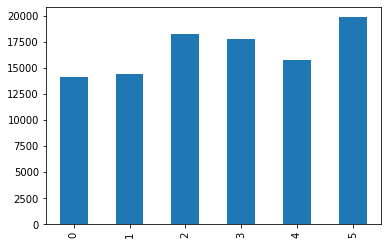

In [3]:
# select subset of data
target_classes = [0,1,2,3,4,5]
num_classes = len(target_classes)
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben'].values.astype(float)
y = zeroone.loc[:,'Aktion']
D = X.shape[1]
# print distribution over classes
y.value_counts().sort_index().plot(kind='bar');
y = y.values.astype(float).reshape(-1,1)

## Function to evaluate and save a model

In [4]:
import pathlib
def evaluate(X_train, y_train, kernel, kernel_args, n_classes, inducing_every, ftol=1e-10, name=None, path='./models/07_Jass_GPFlow_multi/', overwrite=False):
    
    if not name is None:
        _path = pathlib.Path(path)
        if not _path.is_dir():
            raise Exception('path to store model does not exist: %s' % path)
        _file = pathlib.Path(path+name)
        if _file.exists():
            if overwrite:
                _file.unlink()
            else:
                print('%s already trained... continue' % (str(path+name)))
                return
    # clear default tensorflow graph/session from previous trainings/predictions
    gpflow.reset_default_graph_and_session()
    
    kern = kernel(**kernel_args)
    
    print('Evaluating kernel: '+kern.name + ' (' + name+ ')')
    print('Datasets: Train: %i (%i inducing variables)' % (len(y_train), len(y_train)//inducing_every))
    
    
    #model
    invlink = gpflow.likelihoods.RobustMax(n_classes) # Robustmax inverse link function
    likelihood = gpflow.likelihoods.MultiClass(n_classes, invlink=invlink)  # Multiclass likelihood

    Z = X_train[::inducing_every].copy()
    m = gpflow.models.SVGP(
        X_train, y_train, kern=kern, likelihood=likelihood,
        Z=Z, num_latent=num_classes, whiten=True, q_diag=True)
    
    # train
    opt = gpflow.train.ScipyOptimizer(options={'maxls': 30,'ftol':ftol, 'disp':False})
    opt.minimize(m, maxiter=notebook_niter(8000))
    
    # save model
    if not name is None:
        saver = gpflow.saver.Saver()
        saver.save(path+name, m)

In [5]:
def load_model(name, path='./models/07_Jass_GPFlow_multi/'):
    gpflow.reset_default_graph_and_session()
    return gpflow.saver.Saver().load(path+name)

def accuracy(m, X, y):
    return np.equal(y.reshape(-1), np.argmax(m.predict_y(X)[0], axis=1)).mean()

def create_name(name, train_size, inducing_every):
    return name+'_'+str(train_size)+'_'+str(train_size//inducing_every)

# Baseline using Squared Exponential on 500/250 training samples

In [6]:
# prepare data
_train_size = 500
_test_size = 10000
_inducing_every = 2
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)    

In [8]:
# traind and save
%time
_name = create_name('rbf', _train_size, _inducing_every)
r = evaluate(
     X_train=X_train,
     y_train=y_train,
     kernel= gpflow.kernels.RBF,
     kernel_args = {'input_dim': D},
     n_classes=num_classes,
     inducing_every=_inducing_every,
     name=_name, overwrite=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.72 µs
./models/07_Jass_GPFlow_multi/rbf_500_250 already trained... continue


In [10]:
# load and predict metrics
m = load_model(_name)
print('Log Marginal Likelihood: %.2f\nTest Accuracy: %.2f' % (m.compute_log_likelihood(), accuracy(m, X_test, y_test)))

./models/07_Jass_GPFlow_multi/rbf_500_250
Log Marginal Likelihood: -947.93
Test Accuracy: 0.69


# Testing Multiple Kernels 

In [99]:
kernels = {
    'rbf' : (gpflow.kernels.RBF, {'input_dim' : D}),
    'rbf_ard' : (gpflow.kernels.RBF, {'input_dim' : D, 'ARD':True}),
    'mat52' : (gpflow.kernels.Matern52, {'input_dim' : D}),
    'mat32' : (gpflow.kernels.Matern32, {'input_dim' : D}),
    'linear' : (gpflow.kernels.Linear, {'input_dim' : D}),
    'linear_ard' : (gpflow.kernels.Linear, {'input_dim' : D, 'ARD':True}),
    'arccosine' : (gpflow.kernels.ArcCosine, {'input_dim' : D}),
    'rq' : (gpflow.kernels.RationalQuadratic, {'input_dim' : D})
}

In [10]:
# prepare data
_train_size = 500
_test_size = 10000
_inducing_every = 2
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)    

In [101]:
# traind and save
for name, kernel in kernels.items():
    _name = create_name(name, _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= kernel[0],
         kernel_args= kernel[1],
         n_classes=num_classes,
         inducing_every=_inducing_every,
         name=_name)

./models/07_Jass_GPFlow_multi/rbf_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/rbf_ard_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/mat52_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/mat32_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/linear_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/linear_ard_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/arccosine_500_250 already trained... continue
./models/07_Jass_GPFlow_multi/rq_500_250 already trained... continue


In [25]:
for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

rbf_500_250
Log Marginal Likelihood: -947.93
Train Accuracy: 0.96
Test Accuracy: 0.69

rbf_ard_500_250
Log Marginal Likelihood: -917.86
Train Accuracy: 0.97
Test Accuracy: 0.69

mat52_500_250
Log Marginal Likelihood: -949.60
Train Accuracy: 0.94
Test Accuracy: 0.68

mat32_500_250
Log Marginal Likelihood: -1007.74
Train Accuracy: 0.94
Test Accuracy: 0.69

linear_500_250
Log Marginal Likelihood: -914.09
Train Accuracy: 0.91
Test Accuracy: 0.66

linear_ard_500_250
Log Marginal Likelihood: -887.05
Train Accuracy: 0.90
Test Accuracy: 0.65

arccosine_500_250
Log Marginal Likelihood: -2363.56
Train Accuracy: 0.64
Test Accuracy: 0.54

rq_500_250
Log Marginal Likelihood: -954.65
Train Accuracy: 0.95
Test Accuracy: 0.69



In [102]:
marginal_likelihoods = []
train_acc = []
test_acc = []
labels = []

for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    marginal_likelihoods.append(m.compute_log_likelihood())
    train_acc.append(accuracy(m, X_train,y_train))
    test_acc.append(accuracy(m, X_test,y_test))
    labels.append(name)
                    

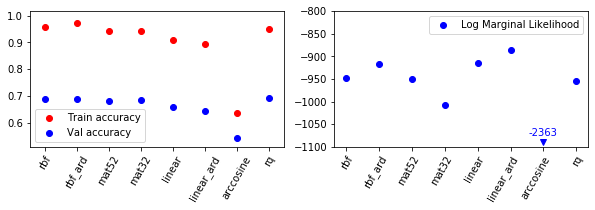

In [115]:
fig, ax = plt.subplots(1,2, figsize=(10,2.5))
x = np.arange(len(train_acc))
ax[0].scatter(x, train_acc, color='r', label='Train accuracy')
ax[0].scatter(x, test_acc, color='b', label='Val accuracy')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation=60);
ax[0].legend()

ax[1].scatter(x, marginal_likelihoods,color='b',  label='Log Marginal Likelihood')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation=60, ha='right', rotation_mode="anchor");
ax[1].set_ylim(-1100,-800)
ax[1].plot([6],[-1090], marker='v',color='b')
ax[1].text(5.55, -1075, '-2363', color='b')
ax[1].legend();

## Linear (ARD) and RBF (ARD) on 1000/333 training samples

In [26]:
# prepare data
_train_size = 1000
_test_size = 10000
_inducing_every = 3
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)  

In [27]:
kernels = {
    'rbf_ard' : (gpflow.kernels.RBF, {'input_dim' : D, 'ARD':True}),
    'linear_ard' : (gpflow.kernels.Linear, {'input_dim' : D, 'ARD':True})
}

In [28]:
# traind and save
for name, kernel in kernels.items():
    _name = create_name(name, _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= kernel[0],
         kernel_args= kernel[1],
         n_classes=num_classes,
         inducing_every=_inducing_every,
         name=_name)

./models/07_Jass_GPFlow_multi/rbf_ard_1000_333 already trained... continue
./models/07_Jass_GPFlow_multi/linear_ard_1000_333 already trained... continue


In [29]:
for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

rbf_ard_1000_333
Log Marginal Likelihood: -1660.61
Train Accuracy: 0.95
Test Accuracy: 0.72

linear_ard_1000_333
Log Marginal Likelihood: -1766.03
Train Accuracy: 0.87
Test Accuracy: 0.68



## RBF (ARD) on 2000/500 training samples

In [40]:
# prepare data
_train_size = 2000
_test_size = 10000
_inducing_every = 4
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)  

In [41]:
kernels = {
    'rbf_ard' : (gpflow.kernels.RBF, {'input_dim' : D, 'ARD':True})
}

In [42]:
# traind and save
for name, kernel in kernels.items():
    _name = create_name(name, _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= kernel[0],
         kernel_args= kernel[1],
         n_classes=num_classes,
         inducing_every=_inducing_every,
         name=_name)

./models/07_Jass_GPFlow_multi/rbf_ard_2000_500 already trained... continue


In [43]:
for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

rbf_ard_2000_500
Log Marginal Likelihood: -3006.32
Train Accuracy: 0.94
Test Accuracy: 0.74



## RBF (ARD) on 4000/500 training samples

In [34]:
# prepare data
_train_size = 4000
_test_size = 10000
_inducing_every = 8
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)  

In [35]:
kernels = {
    'rbf_ard' : (gpflow.kernels.RBF, {'input_dim' : D, 'ARD':True})
}

In [37]:
%%time
# traind and save
for name, kernel in kernels.items():
    _name = create_name(name, _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= kernel[0],
         kernel_args= kernel[1],
         n_classes=num_classes,
         inducing_every=_inducing_every,
         name=_name)

Evaluating kernel: SquaredExponential (rbf_ard_4000_500)
Datasets: Train: 4000 (500 inducing variables)
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5990.350781
  Number of iterations: 8000
  Number of functions evaluations: 8518


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5990.350781
  Number of iterations: 8000
  Number of functions evaluations: 8518


CPU times: user 3h 50min 17s, sys: 1h 34min 8s, total: 5h 24min 25s
Wall time: 1h 16min 35s


/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


In [39]:
for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

rbf_ard_4000_500
Log Marginal Likelihood: -5987.75
Train Accuracy: 0.92
Test Accuracy: 0.76



## RBF (ARD) on plain 4000 training samples (no inducing points)

Trained on google colab GPU engine with 16G Memory (took 5h25 / 3h30 wall time)

In [6]:
# prepare data
_train_size = 4000
_test_size = 10000
_inducing_every = None
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)  

In [8]:
m = load_model(_name)
_name = 'rbf_ard_4000'
print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


rbf_ard_4000
Log Marginal Likelihood: -4571.78
Train Accuracy: 0.98
Test Accuracy: 0.75



## RBF (ARD) on 10000/3333 training samples

In [6]:
# prepare data
_train_size = 10000
_test_size = 10000
_inducing_every = 3
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=_train_size, test_size=_test_size, random_state=23)  

In [7]:
kernels = {
    'rbf_ard' : (gpflow.kernels.RBF, {'input_dim' : D, 'ARD':True})
}

In [8]:
%%time
# traind and save
for name, kernel in kernels.items():
    _name = create_name(name, _train_size, _inducing_every)
    r = evaluate(
         X_train=X_train,
         y_train=y_train,
         kernel= kernel[0],
         kernel_args= kernel[1],
         n_classes=num_classes,
         inducing_every=_inducing_every,
         ftol=1e-2,
         name=_name, overwrite=False)

Evaluating kernel: SquaredExponential (rbf_ard_10000_3333)
Datasets: Train: 10000 (3333 inducing variables)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21775.320796
  Number of iterations: 19
  Number of functions evaluations: 24


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 21775.320796
  Number of iterations: 19
  Number of functions evaluations: 24
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:37: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:


CPU times: user 29min 49s, sys: 2min 43s, total: 32min 32s
Wall time: 9min 42s


In [8]:
for name, kernel in kernels.items():
    _name = name+'_'+str(_train_size)+'_'+str(_train_size//_inducing_every)
    m = load_model(_name)
    print('%s\nLog Marginal Likelihood: %.2f\nTrain Accuracy: %.2f\nTest Accuracy: %.2f\n' % (_name, m.compute_log_likelihood(), accuracy(m, X_train,y_train), accuracy(m, X_test,y_test)))

/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:46: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(pathname_or_file_like) as h5file:
/usr/local/lib/python3.6/dist-packages/gpflow/saver/serializers.py:47: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return h5file['data'].value



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


rbf_ard_10000_3333
Log Marginal Likelihood: -21772.72
Train Accuracy: 0.86
Test Accuracy: 0.78



### Export Test inputs/truth/predictions for demo app

In [37]:

for i in range(200):
    sample = i
    print("{ hand: "+str(X_test[sample].astype(np.int).tolist())+", prediction: \'"+(['Ecke', 'Herz', 'Schaufel', 'Kreuz', 'Obenabe', 'Undenufe'][np.argmax(m.predict_f([X_test[sample]])[0])])+"', truth: \'"+(['Ecke', 'Herz', 'Schaufel', 'Kreuz', 'Obenabe', 'Undenufe'][int(y_test[sample])])+"'},")

{ hand: [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0], prediction: 'Schaufel', truth: 'Schaufel'},
{ hand: [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0], prediction: 'Schaufel', truth: 'Schaufel'},
{ hand: [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1], prediction: 'Undenufe', truth: 'Undenufe'},
{ hand: [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], prediction: 'Herz', truth: 'Undenufe'},
{ hand: [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1], prediction: 'Schaufel', truth: 'Schaufel'},
{ hand: [1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0], prediction: 'Schaufel', truth: 'Schaufel'},
{ hand: [0, 0,

<BarContainer object of 37 artists>

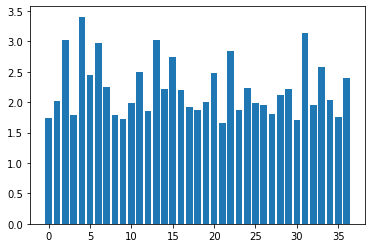

In [12]:
ls = m.kern.lengthscales.value
plt.bar(np.arange(len(ls)), ls)

# Visualization for Report

In [13]:
models = [
    'rbf_ard_1000_333',
    'linear_ard_1000_333',
    'rbf_ard_2000_500',
    'rbf_ard_4000_500',
    'rbf_ard_10000_3333',
]

In [14]:
marginal_likelihoods = []
train_acc = []
test_acc = []
labels = []

for name in models:
    m = load_model(name)
    marginal_likelihoods.append(m.compute_log_likelihood())
    train_acc.append(accuracy(m, X_train,y_train))
    test_acc.append(accuracy(m, X_test,y_test))
    labels.append(name)
                    

### Bigger models were exectued on google collab

In [15]:
labels_big = [
    'rbf_ard_4000',
    'rbf_ard_4000_4000',
    'rbf_ard_12000_6000_tol-2',
    'rbf_ard_15000_5000_tol-1',
    'rbf_ard_15000_5000_tol-2',
    'rbf_ard_15000_5000_tol-3',
    'rbf_ard_15000_5000_tol-6']

train_acc_all = train_acc + [0.833, 0.838, 0.868, 0.772, 0.854, 0.859, 0.918]
test_acc_all = test_acc + [0.754, 0.758, 0.784, 0.726, 0.787, 0.786, 0.772]
labels_all = labels + labels_big

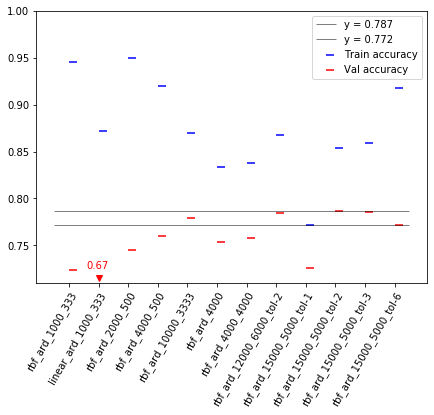

In [20]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
x = np.arange(len(train_acc_all))
plt.hlines(0.787,-0.5,11.5,linewidth=1,color=[0,0,0,0.5], label='y = 0.787')
plt.hlines(0.772,-0.5,11.5,linewidth=1,color=[0,0,0,0.5], label='y = 0.772')
ax.scatter(x, train_acc_all,marker=1,s=70, color='b', label='Train accuracy')
ax.scatter(x, test_acc_all, marker=1,s=70, color='r', label='Val accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels_all, rotation=60, ha='right', rotation_mode="anchor");
ax.set_ylim(0.71,1)
ax.plot([1],[0.715], marker='v',color='r')
ax.text(0.6,0.725,'0.67', color='r')
ax.legend()